In [1]:
# import basic modules
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.coordinates import SkyCoord

from easycat.download import WISEDataArchive
from easycat.lightcurve.plot import plot_wiselc, plot_positions
from easycat.lightcurve.reprocess import ReprocessFactory

## Downloading WISE Lightcurve

In [2]:
# position of target
pos_ref = SkyCoord(ra=153.38352, dec=26.47322, unit="deg", frame="fk5")

# instantiate a downloader
arch = WISEDataArchive()

# retrieve WISE photometric data from IRSA
is_successful, lcurve = arch.retrieve_photo_for_item(
    item_id="test_obj",
    coord=pos_ref,
    radius=6*u.arcsec, # <-- matching radius
    return_data=True
)

print("Is successful?", is_successful)

Is successful? True


In [3]:
print(type(lcurve)) # a pandas DataFrame
print(lcurve.columns)

<class 'pandas.core.frame.DataFrame'>
Index(['raj2000', 'dej2000', 'mjd', 'w1mag', 'w1sigmag', 'w1rchi2', 'w2mag',
       'w2sigmag', 'w2rchi2', 'na', 'nb', 'qi_fact', 'cc_flags', 'saa_sep',
       'moon_masked', 'qual_frame'],
      dtype='object')


## Reprocessing WISE Data

In [4]:
# Firstly, we need to get a WISE Reprocessor from Reprocess Factory
repro = ReprocessFactory.get(metadata={ "telescope": "WISE" })

# Our default pipeline:
# 1. Sort data by MJD
# 2. Filter missing data
# 3. criteria_basic
# 4. DBSCAN
# 5. filter outliers
lcurve_repro = repro.reprocess(lcurve=lcurve, pos_ref=pos_ref)


# clean epoch
# at least 5 points per epoch
lcurve_repro = repro.clean_epoch(lcurve_repro, n_least=5)

**Tip**
You can directly use `WISEReprocessor` instead of `ReprocessFactory.get`:
```Python
from easycat.lightcurve.reprocess import WISEReprocessor
repro = WISEReprocessor()
```

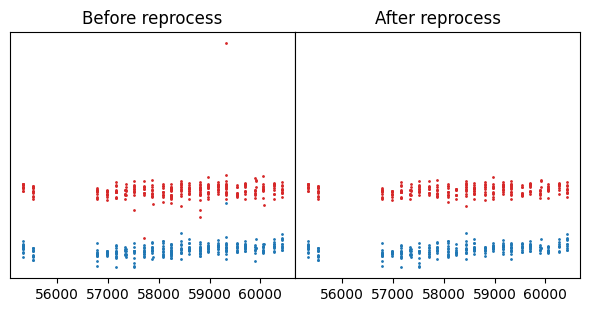

In [5]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))

axs[0].scatter(lcurve.mjd, lcurve.w1mag, c="tab:blue", s=1)
axs[0].scatter(lcurve.mjd, lcurve.w2mag, c="tab:red",  s=1)
axs[0].yaxis.set_inverted(True)

axs[1].scatter(lcurve_repro.mjd, lcurve_repro.w1mag, c="tab:blue", s=1)
axs[1].scatter(lcurve_repro.mjd, lcurve_repro.w2mag, c="tab:red",  s=1)
axs[1].set_yticks([])

fig.tight_layout(w_pad=0)

axs[0].set_title("Before reprocess")
axs[1].set_title("After reprocess")
plt.show()

## Generating Long-term WISE Lightcurve

Then let us generate long-term WISE lightcurve,

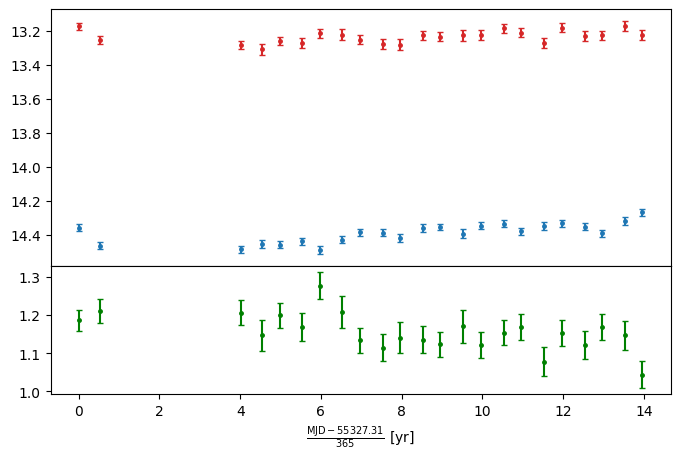

In [6]:
longterm = repro.generate_longterm_lcurve(lcurve_repro, max_interval=10)
fig = plot_wiselc(lcurve=longterm)
plt.show()

To quantitatively variability, we can calculate the intrinsic amplitude of variability $\sigma_m$. The $\sigma_m$ can be calculated using the Python function `easycat.lightcurve.features.sigma_m`.

In [7]:
from easycat.lightcurve.features import sigma_m

w1varamp, w1ratio, w1err = sigma_m(longterm, valname="w1mag", errname="w1sigmag", err_sys=0.024, redshift=0.04027)
w2varamp, w2ratio, w2err = sigma_m(longterm, valname="w2mag", errname="w2sigmag", err_sys=0.028, redshift=0.04027)

print(f"w1varamp={w1varamp:.4f}, w1err={w1err:.4f}, w1ratio=(w1varamp/w1err)/sqrt(1+z)={w1ratio:.3f}")
print(f"w2varamp={w2varamp:.4f}, w2err={w2err:.4f}, w2ratio=(w2varamp/w2err)/sqrt(1+z)={w2ratio:.3f}")

w1varamp=0.0485, w1err=0.0325, w1ratio=(w1varamp/w1err)/sqrt(1+z)=1.465
w2varamp=0.0000, w2err=0.0398, w2ratio=(w2varamp/w2err)/sqrt(1+z)=0.000


## Color-Magnitude Diagram

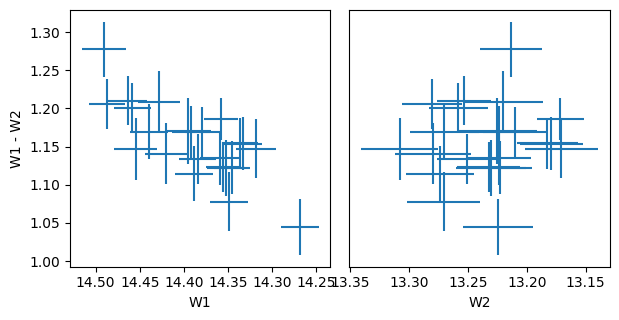

In [8]:
# plot color-magnitude diagram
color = longterm.w1mag - longterm.w2mag
sigcolor = np.sqrt(longterm.w1sigmag**2 + longterm.w2sigmag**2)

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
axs[0].errorbar(longterm.w1mag, color, xerr=longterm.w1sigmag, yerr=sigcolor, linestyle="none")
axs[1].errorbar(longterm.w2mag, color, xerr=longterm.w2sigmag, yerr=sigcolor, linestyle="none")

axs[0].xaxis.set_inverted(True)
axs[1].xaxis.set_inverted(True)

axs[0].set_xlabel("W1")
axs[1].set_xlabel("W2")

axs[0].set_ylabel("W1 - W2")
axs[1].yaxis.set_visible(False)

fig.tight_layout(pad=0)

plt.show()

In [9]:
from scipy.stats import spearmanr

rho_w1, p_w1 = spearmanr(longterm.w1mag, color)
rho_w2, p_w2 = spearmanr(longterm.w2mag, color)

print("\trho_spearman\tp-value")
print(f"W1:\t{rho_w1:.2f}    \t{p_w1*100:.2f}%")
print(f"W2:\t{rho_w2:.2f}    \t{p_w2*100:.2f}%")

	rho_spearman	p-value
W1:	0.67    	0.04%
W2:	-0.19    	37.84%


How to consider the uncertainties on magnitude and color? Monte Carlo error analyses can be used, and we provide three methods: **resampling**, **perturbation**, and **composite**. 

More information can refer to `DOI: 10.48550/arXiv.1411.3816`.

In [10]:
from easycat.stats.montecarlo import spearmanr_mc

rho, zscore = spearmanr_mc(
    x=longterm.w1mag, y=color,
    xerr=longterm.w1sigmag, yerr=sigcolor,
    method="perturbation",
    N=1000
)

rho.sort()
zscore.sort()

rho_Spearman: 0.51 (0.38, 0.64)
P(rho_Spearman > 0.4) = 81.80%


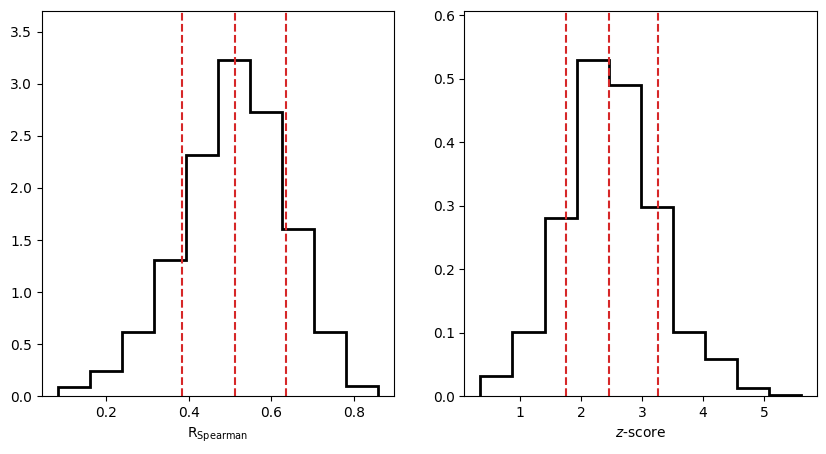

In [11]:
def plot_hist(ax, data):
    N = int(len(data)*15.9/100)
    data_best = np.median(data)
    data_lower = data[N]
    data_upper = data[-N]

    vals, _, _ = ax.hist(data, density=True, color="k", histtype="step", linewidth=2)
    ylim = np.max(vals)
    ylim = ylim + ylim/7
    ax.vlines([data_best, data_lower, data_upper], 0, ylim, color="tab:red", linestyle="--")
    ax.set_ylim(0, ylim)
    return data_best, data_lower, data_upper

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

rho_best, rho_lower, rho_upper = plot_hist(axs[0], rho)
zscore_best, zscore_lower, zscore_upper = plot_hist(axs[1], zscore)

axs[0].set_xlabel("$\\rm R_{Spearman}$")
axs[1].set_xlabel("$z$-score")

print(f"rho_Spearman: {rho_best:.2f} ({rho_lower:.2f}, {rho_upper:.2f})")
print(f"P(rho_Spearman > 0.4) = {len(rho[rho>0.4])/len(rho)*100:.2f}%")

plt.show()

## More patterns to download

### Downloading a catalog

In [12]:
catalog = pd.DataFrame(data=[
    ("J150941.18+184601.0", 227.4216, 18.7669),
    ("J140034.70+004733.4", 210.1446, 0.7926),
    ("J120847.81+671833.8", 182.1992, 67.3094)
], columns=["obj_id", "raj2000", "dej2000"])
catalog.set_index(keys="obj_id", inplace=True)

**Tip**
You can create the `catalog` by reading from Excel Table or other local file. For example,
``` Python
catalog = pd.read_csv("test.csv")
catalog.rename(columns={
    "RA": "raj2000",
    "Dec": "dej2000"
}, inplace=True)
catalog.set_index(keys="Name", inplace=True)
```

In [13]:
store_dir = "./wisedata/"
checkpoint = "wisedata_checkpoint.pkl"
os.makedirs(store_dir, exist_ok=True)

arch = WISEDataArchive()

record = arch.retrieve_photo(
    catalog=catalog,
    radius=6*u.arcsec,

    store_dir=store_dir, # <-- store WISE data under store_dir
    return_data=False,
    n_works=10,
    checkpoint=checkpoint
)

if len(record.get("completed")) == len(catalog):
    os.remove(checkpoint)

Creating log file [wisedata_checkpoint.pkl] ... Completed.



Summary
Total: 3
Completed: 3
Failed: 0
Cancelled: 0


A typical code snippet for batch processing of lightcurves:

In [14]:
from astropy.table import Table
from astropy.io import fits
from easycat.lightcurve.reprocess import WISEReprocessor

store_dir = "./wisedata/"
repro_dir = "./wisedata_repro/"
os.makedirs(repro_dir, exist_ok=True)

repro = WISEReprocessor()

# `catalog_repro` is used to store reprocessed results
# sources that fail the reprocessing procedure will be excluded
catalog_repro = pd.DataFrame(columns=catalog.columns)

for obj_id, row in catalog.iterrows():
    # load lightcurve data
    filepath = os.path.join(store_dir, obj_id+".fits")
    if not os.path.isfile(filepath):
        print(f"WARNING: {obj_id} doesn't exist")
        continue

    try:
        with fits.open(os.path.join(store_dir, obj_id+".fits")) as hdul:
            lcurve = Table(hdul[1].data).to_pandas()

        pos_ref = SkyCoord(ra=row["raj2000"], dec=row["dej2000"], unit="deg", frame="fk5")

        # reprocess data
        lcurve_repro = repro.reprocess(lcurve=lcurve, pos_ref=pos_ref)
        lcurve_repro = repro.clean_epoch(lcurve_repro, n_least=5)

        # generate long-term lightcurve
        longterm = repro.generate_longterm_lcurve(lcurve_repro, 1.2)
    except:
        print(f"ERROR: {obj_id}")
        continue

    # at least 5 epochs
    if len(longterm) < 5:
        continue

    # save result
    catalog_repro.loc[obj_id] = row
    repropath = os.path.join(repro_dir, obj_id+".csv")
    longterm.to_csv(repropath, index=False)

assert len(catalog_repro) <= len(catalog)

## Why DBSCAN?
A large matching radius risks blending photometric data from multiple sources, but clustering algorithms can mitigate this effect.

In [15]:
pos_ref = SkyCoord(ra=182.1992, dec=67.3094, unit="deg", frame="fk5")

arch = WISEDataArchive()

is_successful, lcurve = arch.retrieve_photo_for_item(
    item_id="test_obj",
    coord=pos_ref,
    radius=6*u.arcsec,
    return_data=True
)

lcurve_repro = repro.reprocess(lcurve=lcurve, pos_ref=pos_ref)

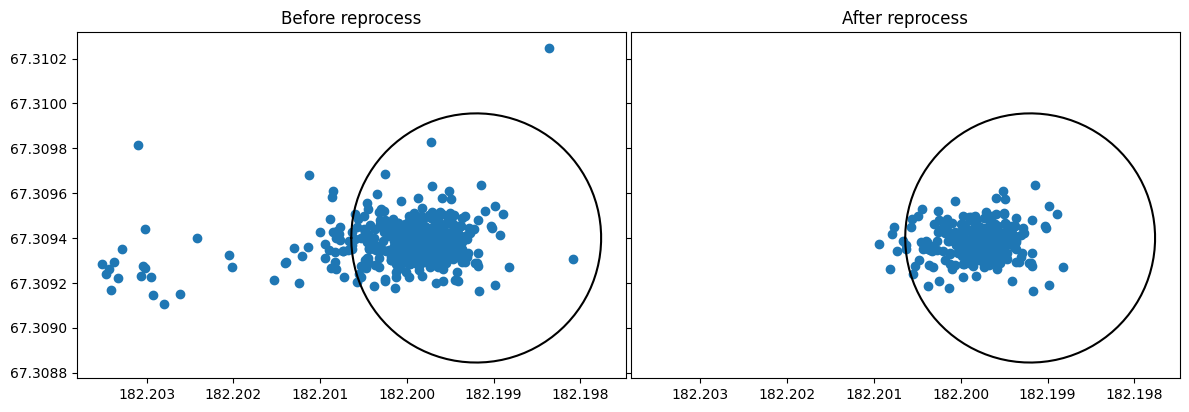

In [16]:
wise_pos = SkyCoord(ra=lcurve["raj2000"], dec=lcurve["dej2000"], unit="deg", frame="fk5")
wise_pos_repro = SkyCoord(ra=lcurve_repro["raj2000"], dec=lcurve_repro["dej2000"], unit="deg", frame="fk5")

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4))


plot_positions(axs[0], wise_pos, pos_ref)
plot_positions(axs[1], wise_pos_repro, pos_ref)

fig.tight_layout(w_pad=0)

axs[0].set_title("Before reprocess")
axs[1].set_title("After reprocess")

plt.show()